# Hierarchical Clustering
Hierarchical clustering is a general family of clustering algorithms that build nested clusters by merging or splitting them successively. This hierarchy of clusters is represented as a tree (or dendrogram). The root of the tree is the unique cluster that gathers all the samples, the leaves being the clusters with only one sample.

**Bottom-up clustering** or **agglomerative clustering** treat each document as a singleton cluster and successively merge clusters until a single cluster containing all the documents has created.

Main steps:
- Compute N x N similarity matrix S
- Execute N - 1 steps in which the most similar clusters are merged and the corresponding rows and columns are updated with the similarity of the new merged cluster with all the other clusters 
- Store history of subsequent aggregations

There are different stategies for computing the similarity between clusters for the merging step:
- **single link** $\rightarrow$ $d(\mu, \omega) = \min(d(\mu_i, \omega_j))$
- **complete link** $\rightarrow$ $d(\mu, \omega) = \max(d(\mu_i, \omega_j))$
- **average link** $\rightarrow$ $d(\mu, \omega) = avg(d(\mu_i, \omega_j))$
- **centroid link** $\rightarrow$ $d(\mu, \omega) = \mid\mid \vec{\mu} - \vec{\omega} \mid\mid^2$
- **median link** $\rightarrow$ $d(\mu, \omega)$ = same as 'centroid', but the new centroid is the average of the two cluster centroids
- **ward link** $\rightarrow$ $d(\mu, \omega) = \frac{\mid \mu \mid \mid \omega \mid}{\mid \mu \mid + \mid \omega \mid} \mid\mid \vec{\mu} - \vec{\omega} \mid\mid^2$ this is a measure of how much the sum of squares will increase when we merge clusters.

Cluster selection from the dendogram:
- Cut the dendogram at a specific level of similarity
- Cut the dendogram where the gap between two successive combination similarities is largest
- $K = argmin_{k'} [RSS(k') + \lambda k']$ where $k'$ is the cut threshold that produces $k$ clusters
- Pre-define $K$ and cut the dendogram accordingly

## Init the MEC environment

In [1]:
from IPython.core.display import display, HTML
import nbimporter
from mecdb import MEC
import sklearn.cluster as cls
import numpy as np


def show(doc, w=120):
    style = 'width: ' + str(w) + 'px;'
    try:
        url = doc['image']
    except KeyError:
        url = 'https://cdn0.iconfinder.com/data/icons/large-glossy-icons/512/No.png'
    display(HTML('<img src="' + url + '" style="' + style + '">'))

    
def show_grid(docs, w=120, row=6):
    style = 'width: ' + str(w) + 'px; display: inline;'
    html_row = []
    for doc in docs:
        try:
            url = doc['image']
        except KeyError:
            url = 'https://cdn0.iconfinder.com/data/icons/large-glossy-icons/512/No.png'
        html_row.append('<img src="' + url + '" style="' + style + '">')
        if len(html_row) == row:
            display(HTML("".join(html_row)))
            html_row = []
    display(HTML("".join(html_row)))
    

dataset = 'calzedoniajson_items_0'
mec = MEC(dataset)

Importing Jupyter notebook from mecdb.ipynb


In [2]:
M = mec.dataset_matrix(size=len(mec.dictionary))

# Python SciPy implementation

In [3]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
import numpy as np

Z = linkage(M, 'ward')
print Z

[[  13.          152.            0.            2.        ]
 [ 395.          450.            0.            3.        ]
 [ 404.          451.            0.            4.        ]
 ..., 
 [ 893.          895.           48.42362363  360.        ]
 [ 892.          896.           57.24121255  388.        ]
 [ 883.          897.           65.70316714  450.        ]]


## Cophenetic correlation
The goal is to measure if a dendrogram preserves the pairwise distances between the original unmodeled data points.

Given:
- $d(i, j)$ as the distance between the ith and the jth points
- $t(i, j)$ the dendrogrammatic distance between the model points Ti and Tj. This distance is the height of the node at which these two points are first joined together (<a href="https://en.wikipedia.org/wiki/Cophenetic_correlation">see more</a>)
- $\overline{d}$ and $\overline{t}$ are the average of $d(i, j)$ and $t(i, j)$

$$
c = \frac{\sum\limits_{i<j}(d(i,j)-\overline{d})(t(i,j)-\overline{t})}
{\sqrt{[\sum\limits_{i<j} (d(i,j) - \overline{d})]^2[\sum\limits_{i<j} (t(i,j) - \overline{t})]^2}}
$$

In [4]:
from scipy.spatial.distance import pdist
import time

H, T = {}, {}
methods = ['single', 'complete', 'average', 'ward']
for method in methods:
    start = time.time()
    H[method] = linkage(M, method)
    T[method] = time.time() - start

for method, L in H.items():
    c, coph = cophenet(L, pdist(M))
    print method, c, T[method]

average 0.928630118358 0.0428419113159
single 0.91239983427 0.0517270565033
ward 0.195873517874 0.0428040027618
complete 0.788620651773 0.0422139167786


In [5]:
print H[method][0]

[  13.  152.    0.    2.]


The linkage matrix contains a row for each step of the algorithm. The structure of a step in the linkage matrix is:

$$\langle i, j, \sigma, \kappa \rangle$$

where:
- $\sigma$ is the distance observed between $i$ and $j$
- $\kappa$ is the number of objects clustered in the step
- $i$ if $i < \mid D \mid$, $i$ denotes an object in the dataset. Otherwise $i$ denotes the aggregation obtained at step $i - \mid D \mid$. The same for $j$.

## The dendogram

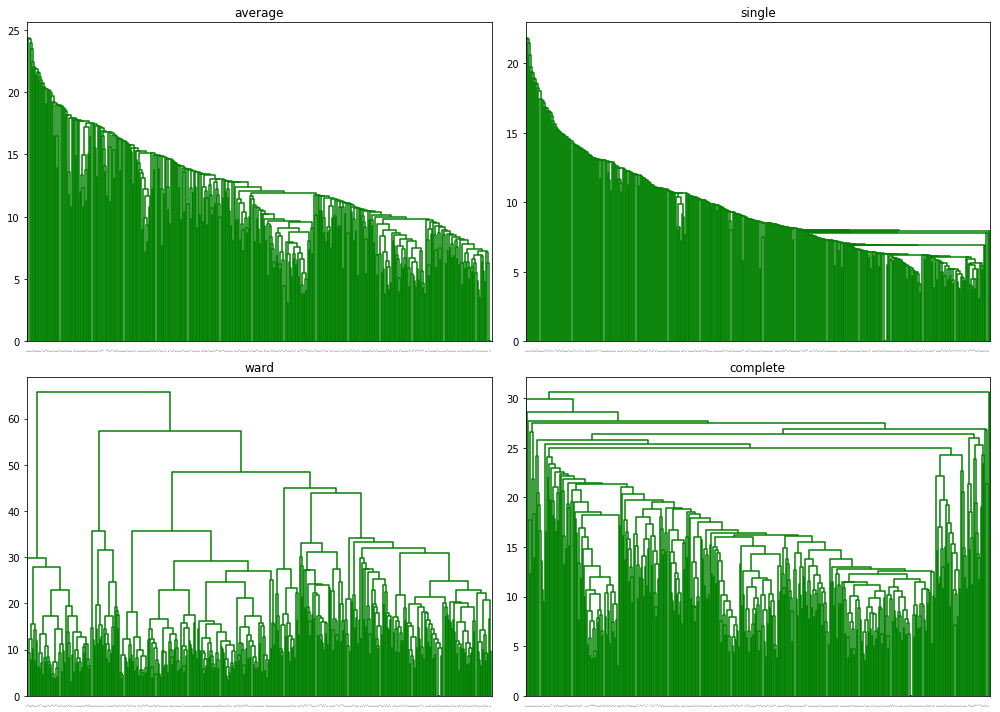

In [6]:
cols = 2
fig, axes = plt.subplots(nrows=int(np.ceil(float(len(H))/cols)), ncols=cols, figsize=(14, 10))
cl = 0
for method, L in H.items():
    axes[cl/cols, cl%cols].set_title(method)
    dendrogram(L,leaf_rotation=90.,leaf_font_size=0,ax=axes[cl/cols, cl%cols],
              color_threshold=100)
    cl += 1
plt.tight_layout()
plt.show()

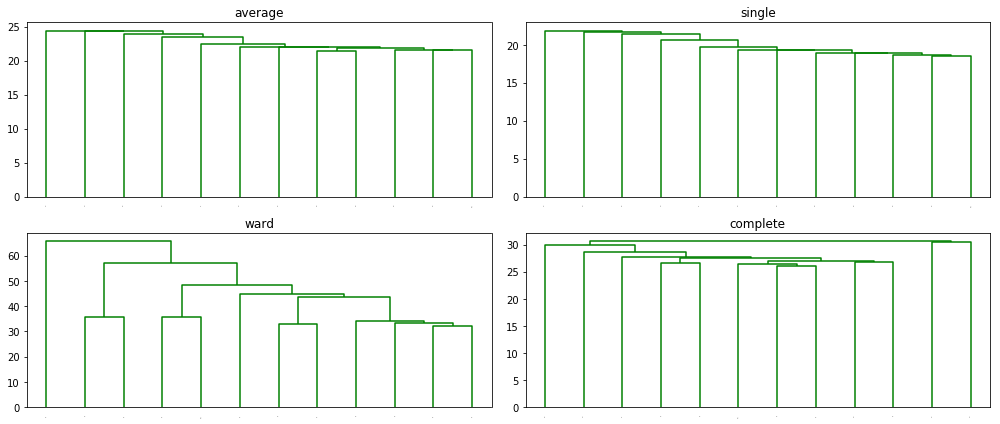

In [7]:
cols = 2
fig, axes = plt.subplots(nrows=int(np.ceil(float(len(H))/cols)), ncols=cols, figsize=(14, 6))
cl = 0
for method, L in H.items():
    axes[cl/cols, cl%cols].set_title(method)
    dendrogram(L,leaf_rotation=90.,leaf_font_size=0,ax=axes[cl/cols, cl%cols],
              truncate_mode='lastp', p=12, show_leaf_counts=True, color_threshold=100)
    cl += 1
plt.tight_layout()
plt.show()

## Setting the cut-off threshold
### Manual set-up

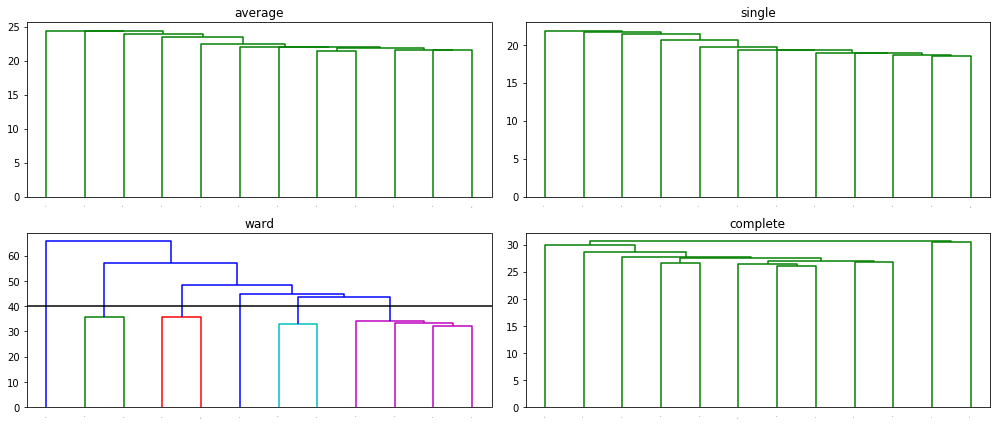

In [8]:
max_d = 40
cols = 2
fig, axes = plt.subplots(nrows=int(np.ceil(float(len(H))/cols)), ncols=cols, figsize=(14, 6))
cl = 0
for method, L in H.items():
    axes[cl/cols, cl%cols].set_title(method)
    dendrogram(L,leaf_rotation=90.,leaf_font_size=0,ax=axes[cl/cols, cl%cols],
              truncate_mode='lastp', p=12, show_leaf_counts=True, color_threshold=max_d)
    axes[cl/cols, cl%cols].axhline(y=max_d, c='k')
    cl += 1
plt.tight_layout()
plt.show()

### Authomatic approach
The scipy dendogram function automatically suggest a threshold for cut-off (colouring) which is 0.7*max(Z[:,2]).

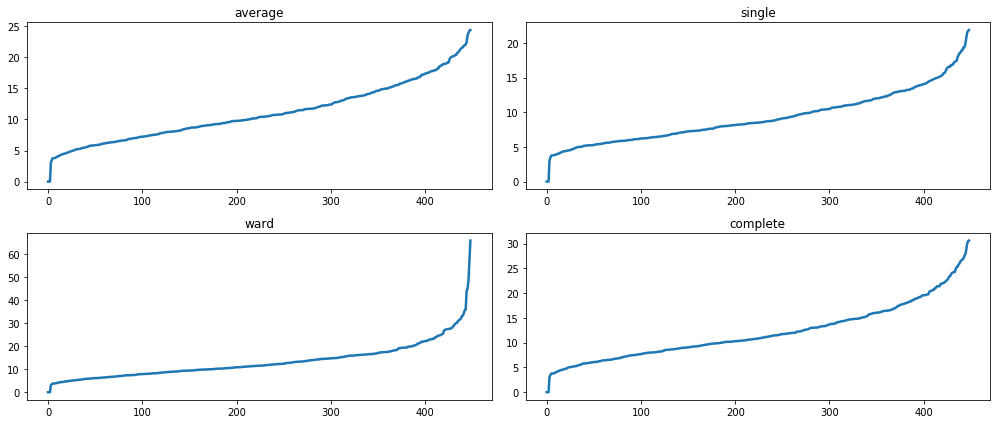

In [9]:
cols = 2
fig, axes = plt.subplots(nrows=int(np.ceil(float(len(H))/cols)), ncols=cols, figsize=(14, 6))
cl = 0
for method, L in H.items():
    axes[cl/cols, cl%cols].set_title(method)
    axes[cl/cols, cl%cols].plot(L[:,2], linewidth=2.5)
    cl += 1
plt.tight_layout()
plt.show()

### Inconsistency
Compare each cluster merge's height $h$ to the average $\mu$ and normalizing it by the standard deviation $\sigma$ formed over the depth previous levels.

Then, select descendants having an inconsistent value less than or equal to $t$ then all its leaf descendants belong to the same flat cluster. When no non-singleton cluster meets this criterion, every node is assigned to its own cluster.

In [10]:
from scipy.cluster.hierarchy import inconsistent, maxinconsts

depth = len(H['ward'])
incons = inconsistent(H['ward'], depth)
print incons #avg, std, count, inconsistency

[[   0.            0.            1.            0.        ]
 [   0.            0.            2.            0.        ]
 [   0.            0.            3.            0.        ]
 ..., 
 [  13.45397716    7.14635479  359.            4.89335437]
 [  13.69168905    7.44529358  387.            5.84926881]
 [  13.28822159    7.71021152  449.            6.79812031]]


### Distance
Observations in each flat cluster have no greater a cophenetic distance than $t$.

### Maxclust
Finds a minimum threshold $r$ so that the cophenetic distance between any two original observations in the same flat cluster is no more than $r$ and no more than $t$ flat clusters are formed.

### Elbow
Finds the clustering step where the acceleration of distance growth is the biggest (the *strongest elbow* of the blue line graph below).

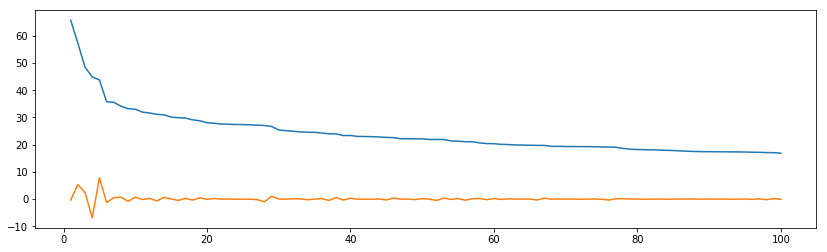

clusters: 4 43.7971036702


In [11]:
limits = 100
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14, 4))
last = H['ward'][:, 2]
last_reverse = last[::-1]
idxs = np.arange(1, len(last) + 1)
axes.plot(idxs[:limits], last_reverse[:limits])

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_reverse = acceleration[::-1]
axes.plot(idxs[:limits], acceleration_reverse[:limits])
plt.show()
k = acceleration_reverse.argmax()  # if idx 0 is the max of this we want 2 clusters
print "clusters:", k, last_reverse[k]

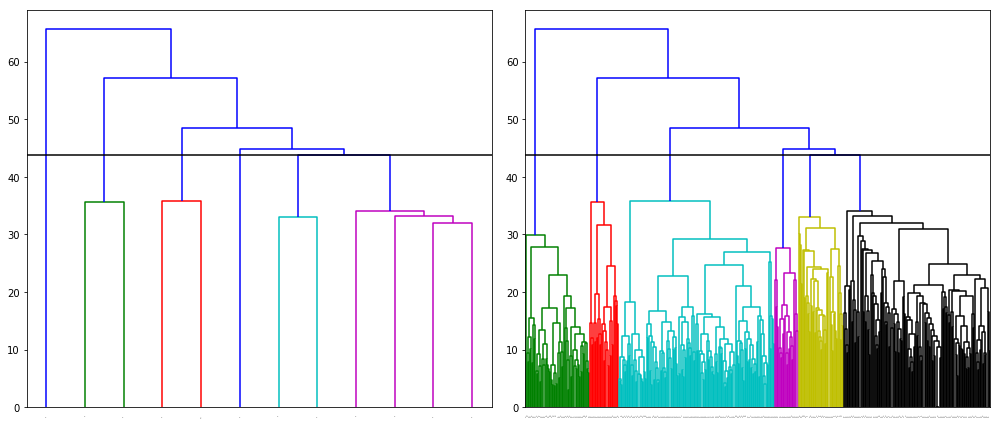

In [12]:
max_d = last_reverse[k]
cols = 2
fig, axes = plt.subplots(nrows=1, ncols=cols, figsize=(14, 6))
dendrogram(H['ward'],leaf_rotation=90.,leaf_font_size=0,ax=axes[0],
          truncate_mode='lastp', p=12, show_leaf_counts=True, color_threshold=last_reverse[k])
axes[0].axhline(y=last_reverse[k], c='k')
dendrogram(H['ward'],leaf_rotation=90.,leaf_font_size=0,ax=axes[1],
          show_leaf_counts=True, color_threshold=last_reverse[k])
axes[1].axhline(y=last_reverse[k], c='k')
plt.tight_layout()
plt.show()

## Retrieve clusters

In [13]:
from scipy.cluster.hierarchy import fcluster

cl = H['ward']
max_d = last_reverse[k]

cl_distance = fcluster(cl, max_d, criterion='distance')
cl_k = fcluster(cl, k, criterion='maxclust')
cl_incons = fcluster(cl, 5, depth=10)

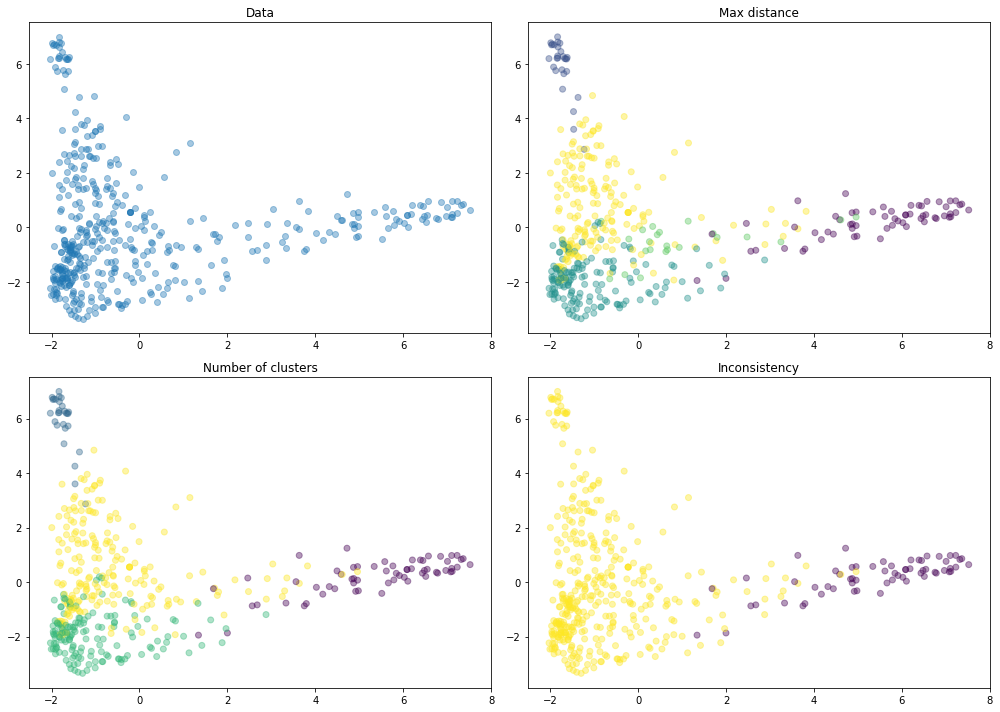

In [14]:
cut_offs = [None, cl_distance, cl_k, cl_incons]
titles = ['Data', 'Max distance', 'Number of clusters', 'Inconsistency']
cols = 2
rows = int(np.ceil(float(len(cut_offs))/cols))
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(14, 10))
for i, labels in enumerate(cut_offs):
    mec.visualize(M, axes[i/cols,i%cols], labels=labels)
    axes[i/cols,i%cols].set_title(titles[i])
plt.tight_layout()
plt.show()



### Show data

In [15]:
docs_per_cluster = 10
partition = dict((x, []) for x in range(1, k+1))
for i, l in enumerate(cl_k):
    partition[l].append(mec.docs[i])
for cluster, resources in partition.items():
    display(HTML('<h2>Cluster '+str(cluster)+'</h2>'))
    show_grid(resources[:docs_per_cluster])